Follow along of Anrej Karpathy's makemore series video 2, this one covers using more complex neural networks to train a next character language model
now has expanded variable context size

Train , validation , test
80%, 10%, 10%S
in practice that 80% is spent tuning paramaters like embedding weights and neuron biases
validation is spent tuning hyper paramSaters like - learning rate, learning rate decay, point of learning rate decay, context size, training length, batch size and more

when loss on train and test are equal it's underfitting and performance can be gained by scaling up dimension of some hyper parameters

In [343]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [345]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [347]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [623]:
#Hyperparamater definition
contextSize = 4
neurons = 250
embeddingSpaceDim = 15
trainSize = 100000
batchSize = 256
learningRate = 0.05
learningDecay = 10

thirty = 30 # couldnt figure out what this parameter actually was and how it should be named?

In [584]:
# build the dataset
block_size = contextSize # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22740, 4]) torch.Size([22740])
torch.Size([22826, 4]) torch.Size([22826])


In [585]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [586]:
#params definition
g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27, embeddingSpaceDim), generator=g)
W1 = torch.randn((thirty, neurons) , generator=g)
b1 = torch.randn(neurons, generator=g)
W2 = torch.rand((neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [590]:
for p in parameters:
    p.requires_grad = True

In [592]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [594]:
lri = []
lossi = []
stepi = []

In [614]:
for i in range(trainSize):
    # Batching, approximate gradient with more steps is better than fewer steps with exact gradients
    ix = torch.randint(0, Xtr.shape[0], (batchSize,), generator=g)

    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, thirty) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update tracking
    #lr = lrs[i]
    lr = learningRate if i < trainSize/1.5 else learningRate / learningDecay
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

learning rate found by plotting 
can then decay this at the end by a factor of 10 to optimize final bit

In [616]:
#evaluate loss on training data
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, thirty) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.8763, grad_fn=<NllLossBackward0>)

In [ ]:
# evaluate loss on validation data

In [617]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, thirty) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0824, grad_fn=<NllLossBackward0>)

In [ ]:
# evaluate loss on test data, got a 2.0599 lower than challenged 2.1701

In [618]:
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, thirty) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.0599, grad_fn=<NllLossBackward0>)

In [ ]:
#plot used to find learning rate

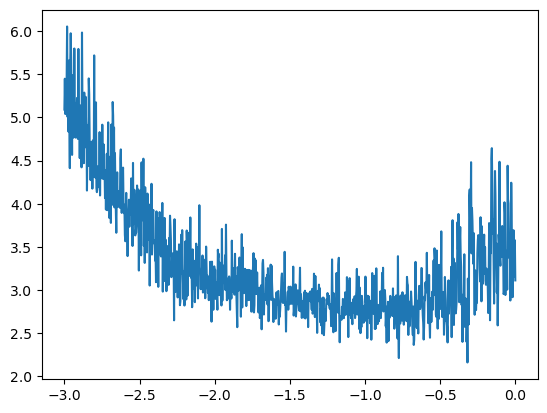

In [203]:
plt.plot(lri, lossi)

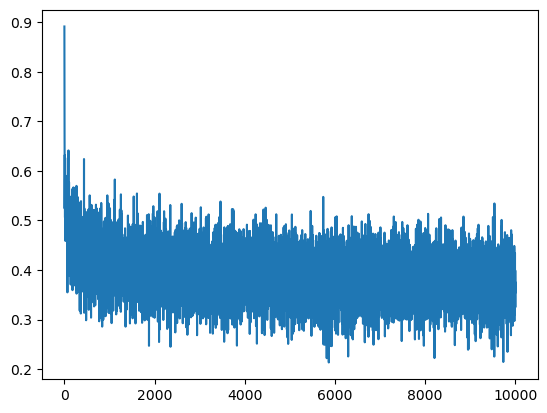

In [307]:
plt.plot(stepi, lossi)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))